In [1]:
import torch
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import evaluate
import faiss
warnings.filterwarnings('ignore')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
generics_kb = load_dataset('community-datasets/generics_kb')
commonsense_qa = load_dataset('tau/commonsense_qa')

print(f"GenericsKB size: {len(generics_kb['train'])}")
print(f"CommonsenseQA train: {len(commonsense_qa['train'])}")
print(f"CommonsenseQA validation: {len(commonsense_qa['validation'])}")

GenericsKB size: 1020868
CommonsenseQA train: 9741
CommonsenseQA validation: 1221


In [4]:
kb_documents = [doc['generic_sentence'] for doc in generics_kb['train']]
print(f"Total KB documents: {len(kb_documents)}")

Total KB documents: 1020868


In [5]:
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
batch_size = 1000
kb_embeddings = []

for i in tqdm(range(0, len(kb_documents), batch_size)):
    batch = kb_documents[i:i + batch_size]
    embeddings = embedding_model.encode(batch, show_progress_bar=False)
    kb_embeddings.append(embeddings)

kb_embeddings = np.vstack(kb_embeddings).astype('float32')
print(f"Embeddings shape: {kb_embeddings.shape}")

100%|██████████| 1021/1021 [03:44<00:00,  4.54it/s]


Embeddings shape: (1020868, 384)


*FAISS for fast semantic similarity search over KB embeddings (with vector normalization)*

In [6]:
dimension = kb_embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)
faiss.normalize_L2(kb_embeddings)
index.add(kb_embeddings)
print(f"Index created with {index.ntotal} vectors")

Index created with 1020868 vectors


In [7]:
def retrieve_context(query, top_k=5, similarity_threshold=0.5):
    query_embedding = embedding_model.encode([query], show_progress_bar=False).astype('float32')
    faiss.normalize_L2(query_embedding)

    distances, indices = index.search(query_embedding, top_k * 2)

    filtered_docs = []
    filtered_scores = []

    for dist, idx in zip(distances[0], indices[0]):
        if dist >= similarity_threshold:
            filtered_docs.append(kb_documents[idx])
            filtered_scores.append(dist)

        if len(filtered_docs) >= top_k:
            break

    return filtered_docs, filtered_scores

In [8]:
test_question = commonsense_qa['validation'][0]['question']
print(f"Test question: {test_question}")
retrieved, scores = retrieve_context(test_question, top_k=5)
print(f"Retrieved documents:")
for i, (doc, score) in enumerate(zip(retrieved, scores)):
    print(f"{i + 1}. (score: {score:.2f}) {doc[:100]}...")

Test question: A revolving door is convenient for two direction travel, but it also serves as a security measure at a what?
Retrieved documents:
1. (score: 0.63) Doors provide security....
2. (score: 0.62) Solid doors provide security....
3. (score: 0.62) Doors have mechanisms....
4. (score: 0.60) A door is a barrier...
5. (score: 0.60) Lockable doors help ensure physical security....


In [9]:
model_name = 'meta-llama/Llama-2-7b-chat-hf'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map='auto',
    trust_remote_code=True
)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMS

In [10]:
def create_prompt_with_rag(question, choices_text, choices_labels, context_docs=None):

    answer_options = '\n'.join([f'{label}: {text}' for label, text in zip(choices_labels, choices_text)])

    if context_docs is None or len(context_docs) == 0:
        # Zero-shot without context
        prompt = f"""You are answering a multiple choice question. Read carefully and choose the best answer.

Question: {question}

Options:
{answer_options}

Instructions:
1. Think step by step
2. Choose only ONE letter: A, B, C, D, or E
3. Your final answer must be a single letter

Answer:"""
    else:
        # RAG with context
        context = '\n'.join([f"- {doc}" for doc in context_docs])
        prompt = f"""Use the following context to answer the multiple choice question.

Context (for reference):
{context}

Question: {question}

Options:
{answer_options}

Instructions:
1. Consider the context above
2. Think step by step
3. Choose only ONE letter: A, B, C, D, or E
4. Your final answer must be a single letter

Answer:"""

    return prompt

In [11]:
def generate_answer(prompt, max_new_tokens=10):
    inputs = tokenizer(
        prompt,
        return_tensors='pt',
        truncation=True,
        max_length=2048,
        padding=True
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.1,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    prompt_length = len(tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True))
    generated_text = response[prompt_length:].strip()

    match = re.search(r'\b([A-E])\b', generated_text.upper())
    if match:
        return match.group(1)

    first_part = generated_text[:20].upper()
    for letter in ['A', 'B', 'C', 'D', 'E']:
        if letter in first_part:
            return letter

    return 'A'

In [12]:
test_data = commonsense_qa['validation']
print(f"Validation set length: {len(test_data)}")

n_samples = 200
test_data = test_data.select(range(min(n_samples, len(test_data))))
print(f"Testing data length: {len(test_data)}")

Validation set length: 1221
Testing data length: 200


In [13]:
bleu = evaluate.load("bleu")
bertscore = evaluate.load("bertscore")

In [14]:
context_sizes = [0, 3, 5, 10]
results = []

for n_context in context_sizes:
    print(f"Evaluating with {n_context} context documents")

    predictions = []
    references = []
    pred_texts = []
    ref_texts = []

    correct_count = 0
    total_count = 0

    for i, example in enumerate(tqdm(test_data, desc=f"{n_context}-context")):
        question = example['question']
        choices_text = example['choices']['text']
        choices_labels = example['choices']['label']
        correct_answer = example['answerKey']

        if n_context > 0:
            context_docs, _ = retrieve_context(question, top_k=n_context, similarity_threshold=0.4)
        else:
            context_docs = None

        prompt = create_prompt_with_rag(question, choices_text, choices_labels, context_docs)
        pred_letter = generate_answer(prompt)

        pred_idx = choices_labels.index(pred_letter) if pred_letter in choices_labels else 0
        ref_idx = choices_labels.index(correct_answer) if correct_answer in choices_labels else 0

        predictions.append(pred_letter)
        references.append(correct_answer)
        pred_texts.append(choices_text[pred_idx])
        ref_texts.append(choices_text[ref_idx])

        if pred_letter == correct_answer:
            correct_count += 1
        total_count += 1

        if i < 3:
            print(f"Example {i+1}:")
            print(f"Question: {question[:80]}...")
            print(f"Predicted: {pred_letter} - {choices_text[pred_idx][:50]}...")
            print(f"Correct: {correct_answer} - {choices_text[ref_idx][:50]}...")
            print(f"Correct so far: {correct_count}/{total_count} ({correct_count/total_count*100:.2f}%)")

    try:
        bleu_score = bleu.compute(
            predictions=pred_texts,
            references=[[r] for r in ref_texts],
            smooth=True
        )['bleu']
    except:
        bleu_score = 0.0

    try:
        bert_results = bertscore.compute(
            predictions=pred_texts,
            references=ref_texts,
            lang='en',
            model_type='roberta-large'
        )
        bert_f1 = float(np.mean(bert_results['f1']))
    except:
        bert_f1 = 0.0

    results.append({
        'n_context': n_context,
        'bleu': bleu_score,
        'bertscore_f1': bert_f1,
        'correct': correct_count,
        'total': total_count
    })

    print(f"{n_context} context documents:")
    print(f"Correct: {correct_count}/{total_count}")
    print(f"BLEU: {bleu_score:.4f}")
    print(f"BERTScore F1: {bert_f1:.4f}")

Evaluating with 0 context documents


0-context:   0%|          | 1/200 [00:01<04:29,  1.35s/it]

Example 1:
Question: A revolving door is convenient for two direction travel, but it also serves as a...
Predicted: A - bank...
Correct: A - bank...
Correct so far: 1/1 (100.00%)


0-context:   1%|          | 2/200 [00:02<03:22,  1.02s/it]

Example 2:
Question: What do people aim to do at work?...
Predicted: A - complete job...
Correct: A - complete job...
Correct so far: 2/2 (100.00%)


0-context:   2%|▏         | 3/200 [00:02<03:02,  1.08it/s]

Example 3:
Question: Where would you find magazines along side many other printed works?...
Predicted: A - doctor...
Correct: B - bookstore...
Correct so far: 2/3 (66.67%)


0-context: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0 context documents:
Correct: 44/200
BLEU: 0.2879
BERTScore F1: 0.9145
Evaluating with 3 context documents


3-context:   0%|          | 1/200 [00:00<03:16,  1.01it/s]

Example 1:
Question: A revolving door is convenient for two direction travel, but it also serves as a...
Predicted: B - library...
Correct: A - bank...
Correct so far: 0/1 (0.00%)


3-context:   1%|          | 2/200 [00:01<03:04,  1.07it/s]

Example 2:
Question: What do people aim to do at work?...
Predicted: B - learn from each other...
Correct: A - complete job...
Correct so far: 0/2 (0.00%)


3-context:   2%|▏         | 3/200 [00:02<02:31,  1.30it/s]

Example 3:
Question: Where would you find magazines along side many other printed works?...
Predicted: B - bookstore...
Correct: B - bookstore...
Correct so far: 1/3 (33.33%)


3-context: 100%|██████████| 200/200 [02:40<00:00,  1.25it/s]


3 context documents:
Correct: 97/200
BLEU: 0.4954
BERTScore F1: 0.9495
Evaluating with 5 context documents


5-context:   0%|          | 1/200 [00:00<03:08,  1.06it/s]

Example 1:
Question: A revolving door is convenient for two direction travel, but it also serves as a...
Predicted: D - mall...
Correct: A - bank...
Correct so far: 0/1 (0.00%)


5-context:   1%|          | 2/200 [00:01<03:00,  1.10it/s]

Example 2:
Question: What do people aim to do at work?...
Predicted: E - talk to each other...
Correct: A - complete job...
Correct so far: 0/2 (0.00%)


5-context:   2%|▏         | 3/200 [00:02<02:32,  1.29it/s]

Example 3:
Question: Where would you find magazines along side many other printed works?...
Predicted: B - bookstore...
Correct: B - bookstore...
Correct so far: 1/3 (33.33%)


5-context: 100%|██████████| 200/200 [02:40<00:00,  1.25it/s]


5 context documents:
Correct: 86/200
BLEU: 0.4061
BERTScore F1: 0.9387
Evaluating with 10 context documents


10-context:   0%|          | 1/200 [00:00<03:16,  1.01it/s]

Example 1:
Question: A revolving door is convenient for two direction travel, but it also serves as a...
Predicted: D - mall...
Correct: A - bank...
Correct so far: 0/1 (0.00%)


10-context:   1%|          | 2/200 [00:01<03:10,  1.04it/s]

Example 2:
Question: What do people aim to do at work?...
Predicted: E - talk to each other...
Correct: A - complete job...
Correct so far: 0/2 (0.00%)


10-context:   2%|▏         | 3/200 [00:02<02:35,  1.26it/s]

Example 3:
Question: Where would you find magazines along side many other printed works?...
Predicted: B - bookstore...
Correct: B - bookstore...
Correct so far: 1/3 (33.33%)


10-context: 100%|██████████| 200/200 [02:34<00:00,  1.30it/s]


10 context documents:
Correct: 94/200
BLEU: 0.4552
BERTScore F1: 0.9409


In [15]:
results_df = pd.DataFrame(results)
print("FINAL RESULTS")
print(results_df.to_string(index=False))

FINAL RESULTS
 n_context     bleu  bertscore_f1  correct  total
         0 0.287873      0.914477       44    200
         3 0.495384      0.949533       97    200
         5 0.406073      0.938679       86    200
        10 0.455245      0.940880       94    200


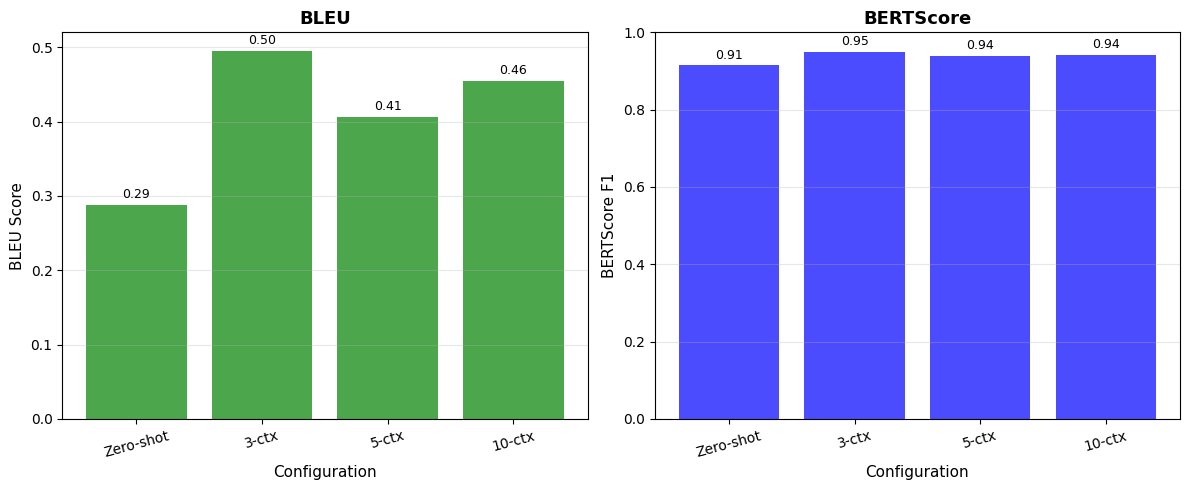

BEST CONFIGURATION
Context documents: 3
BLEU: 0.4954
BERTScore F1: 0.9495


In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

x = np.arange(len(results_df))
labels = [f"{int(n)}-ctx" if n > 0 else "Zero-shot" for n in results_df['n_context']]

# BLEU
axes[0].bar(x, results_df['bleu'], color='green', alpha=0.7)
axes[0].set_xlabel('Configuration', fontsize=11)
axes[0].set_ylabel('BLEU Score', fontsize=11)
axes[0].set_title('BLEU', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels, rotation=15)
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(results_df['bleu']):
    axes[0].text(i, v + 0.005, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

# BERTScore
axes[1].bar(x, results_df['bertscore_f1'], color='blue', alpha=0.7)
axes[1].set_xlabel('Configuration', fontsize=11)
axes[1].set_ylabel('BERTScore F1', fontsize=11)
axes[1].set_title('BERTScore', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels, rotation=15)
axes[1].set_ylim([0, 1.0])
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(results_df['bertscore_f1']):
    axes[1].text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

best_config = results_df.loc[results_df['bertscore_f1'].idxmax()]
print("BEST CONFIGURATION")
print(f"Context documents: {int(best_config['n_context'])}")
print(f"BLEU: {best_config['bleu']:.4f}")
print(f"BERTScore F1: {best_config['bertscore_f1']:.4f}")

#### DistilRoBERTa

In [17]:
embedding_model_2 = SentenceTransformer('sentence-transformers/all-distilroberta-v1')

In [18]:
subset_size = 50000
kb_documents_subset = kb_documents[:subset_size]

kb_embeddings_2 = []
for i in tqdm(range(0, len(kb_documents_subset), batch_size)):
    batch = kb_documents_subset[i:i + batch_size]
    embeddings = embedding_model_2.encode(batch, show_progress_bar=False)
    kb_embeddings_2.append(embeddings)

kb_embeddings_2 = np.vstack(kb_embeddings_2).astype('float32')
print(f"Embeddings shape: {kb_embeddings_2.shape}")

100%|██████████| 50/50 [00:12<00:00,  3.90it/s]

Embeddings shape: (50000, 768)


In [19]:
dimension_2 = kb_embeddings_2.shape[1]
index_2 = faiss.IndexFlatIP(dimension_2)
faiss.normalize_L2(kb_embeddings_2)
index_2.add(kb_embeddings_2)
print(f"Index created with {index_2.ntotal} vectors")

Index created with 50000 vectors


In [20]:
def retrieve_context_2(query, top_k=5):
    query_embedding = embedding_model_2.encode([query], show_progress_bar=False).astype('float32')
    faiss.normalize_L2(query_embedding)
    distances, indices = index_2.search(query_embedding, top_k)
    retrieved_docs = [kb_documents_subset[idx] for idx in indices[0]]
    return retrieved_docs, distances[0]

In [26]:
best_n_context = int(best_config['n_context'])

print(f"Evaluating DistilRoBERTa with {best_n_context} context documents")

test_data_small = test_data.select(range(200))
print(f"Testing on {len(test_data_small)} samples:")

predictions_2 = []
references_2 = []
pred_texts_2 = []
ref_texts_2 = []
correct_count_2 = 0

for i, example in enumerate(tqdm(test_data_small, desc=f"DistilRoBERTa-{best_n_context}")):
    question = example['question']
    choices_text = example['choices']['text']
    choices_labels = example['choices']['label']
    correct_answer = example['answerKey']

    context_docs, _ = retrieve_context_2(question, top_k=best_n_context)

    prompt = create_prompt_with_rag(question, choices_text, choices_labels, context_docs)
    pred_letter = generate_answer(prompt)

    predictions_2.append(pred_letter)
    references_2.append(correct_answer)

    pred_idx = choices_labels.index(pred_letter) if pred_letter in choices_labels else 0
    ref_idx = choices_labels.index(correct_answer) if correct_answer in choices_labels else 0

    pred_texts_2.append(choices_text[pred_idx])
    ref_texts_2.append(choices_text[ref_idx])

    if pred_letter == correct_answer:
        correct_count_2 += 1

Evaluating DistilRoBERTa with 3 context documents
Testing on 200 samples:


DistilRoBERTa-3: 100%|██████████| 200/200 [02:34<00:00,  1.30it/s]


In [27]:
try:
    bleu_score_2 = bleu.compute(predictions=pred_texts_2, references=[[r] for r in ref_texts_2], smooth=True)['bleu']
except:
    bleu_score_2 = 0.0

try:
    bert_results_2 = bertscore.compute(predictions=pred_texts_2, references=ref_texts_2, lang='en')
    bert_f1_2 = float(np.mean(bert_results_2['f1']))
except:
    bert_f1_2 = 0.0

print("DistilRoBERTa Results:")
print(f"Correct: {correct_count_2}/{len(test_data_small)}")
print(f"BLEU: {bleu_score_2:.4f}")
print(f"BERTScore F1: {bert_f1_2:.4f}")

DistilRoBERTa Results:
Correct: 89/200
BLEU: 0.5257
BERTScore F1: 0.9463


In [30]:
comparison_df = pd.DataFrame([
    {'Model': 'MiniLM', 'BLEU': best_config['bleu'], 'BERTScore': best_config['bertscore_f1']},
    {'Model': 'DistilRoBERTa', 'BLEU': bleu_score_2, 'BERTScore': bert_f1_2}
])
print(comparison_df)

           Model      BLEU  BERTScore
0         MiniLM  0.495384   0.949533
1  DistilRoBERTa  0.525651   0.946346


##### Conclusion:

The results show that RAG (Retrieval-Augmented Generation) significantly improves the performance of LLaMA-2 on the CommonsenseQA task compared to zero-shot prompting. The zero-shot baseline achieved only 22% accuracy (44/200 correct), with BLEU of 0.29 and BERTScore of 0.91. Adding retrieved context from the GenericsKB knowledge base enhanced the performance. The optimal configuration used 3 context documents, achieving 48.5% accuracy (97/200 correct), BLEU of 0.50, and BERTScore of 0.95- more than doubling the zero-shot accuracy. This configuration achieves the best balance between providing sufficient commonsense knowledge and avoiding context overload. Increasing context for more than 3 documents (5 or 10) degraded performance slightly, with accuracy dropping to 43% and 47% respectively. This suggests that excessive context may introduce noise or exceed the model's effective context window for this task, leading to confusion rather than improvement. For the embedding model comparison, DistilRoBERTa achieved competitive results with 44.5% accuracy and BLEU of 0.53, performing comparably to all-MiniLM-L6-v2. The similar performance indicates that both embedding models effectively capture semantic similarity for retrieval. It's important to note that DistilRoBERTa was tested on a smaller knowledge base subset (50,000 documents) due to computational constraints, which may have limited its potential.